Homework 5
==========

In this homework...

- Use multivariate linear regression to predict molecular band gap energy from other molecular properties
- Analyze regression parameters with bootstrapping
- Assess goodness of fit of linear models


Problem statement
-----------------------
1. Data has been loaded in for you where independent variables are molecular volume, number of atoms, formation energy, and molecular stability. You will be using these variables to predict the band gap energy, just as in the discussion. Remove all data points which have a value of 0 for the band gap energy, just as in discussion. How many data points does that leave?


2. Standardize the remaining data. For every variable (independent and dependent), subtract the mean and divide the variance from every data point. For each independent variable, plot this variable versus the band gap energy. You can copy everything you need directly from the discussion notebook.


3. Create a multi-variate linear regression model to predict the band gap energy from the other variables (molecular volume, number of atoms, formation energy, and molecular stability). Then, use the model to predict the band gap energy of all the datapoints. Report the $R^2$ value of the regression model.


4. Perform bootstrapping on the multivariate regression problem and create four different histograms, one for each of the $\textit{regression } \textit{parameters}$. You can use the `r2_bootstrapping` function from the discussion, but you will need to edit it to save values and create histograms of regression parameters instead of $R^2$ values.
Bootstrapping requirements: 
    - The number of bootstrapping samples per trial should be equal to the number of data points.
    - Use as many bootstrapping trials as you think are necessary.
    - Plot each histogram of regression parameters on the same plot. There should be 4 different histograms, one for each parameter (volume, number of atoms, formation energy, and molecular stability)


5. Clearly report the mean and variance of each histogram computed in part 4. Round each value to 4 decimal places. Report which independent variable has the bootstrapping histogram with the highest variance.


6. Create a new multi-variate linear regression model to predict the band gap energy from the other variables $\textit{except}$ the highest-variance variable reported in part 5. Use this new model to predict the band gap energy of all the datapoints. Report the $R^2$ value of this new regression model. What is the difference between this $R^2$ value and that in part 3? $\textbf{Hint:}$ If the $R^2$ value is significantly smaller than that in part 3, then the parameter you removed was very important in predicting the band gap energy. If the difference is not very big or if the $R^2$ value is larger, then the parameter removed was useless in predicting the band gap energy. To help you check if your answer to this question is correct, consider what a large variance in the bootstrapping histogram suggests about the variable.

Import the necessary modules

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import json
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score
import random
from sklearn.utils import resample
import scipy.stats as st

Load data from the Open Quantum Materials Database: http://oqmd.org

Citations:
   - http://dx.doi.org/10.1007/s11837-013-0755-4
   - http://dx.doi.org/10.1038/npjcompumats.2015.10

Regression is done on all OQMD molecules containing both tungsten and nitrogen - about 250 molecules

In [44]:
# load data
data_list = []
for i in range(1,6):
    filename = 'data/W/formationenergy'+str(i)+'.json'
    with open(filename) as json_file:
        jfile = json.load(json_file)
        data_list = data_list + (jfile['data'])
df = pd.DataFrame(data_list)

# choose independent variables
indep_vars = ['volume','natoms','stability','delta_e']

# choose dependent variable
dep_var = 'band_gap'

# remove examples with missing values
xs = df[indep_vars].to_numpy()
xs = np.delete(xs,0,0)
ys = df[dep_var].to_numpy()
ys = np.delete(ys,0,0).reshape(-1,1)
all_data = np.concatenate((xs,ys),axis=1)
all_data  = all_data[~np.isnan(all_data).any(axis=1),:]
xs = all_data[:,:len(indep_vars)]
ys = all_data[:,-1]

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}


1. Data has been loaded in for you where independent variables are molecular volume, number of atoms, formation energy, and molecular stability. You will be using these variables to predict the band gap energy, just as in the discussion. Remove all data points which have a value of 0 for the band gap energy, just as in discussion. How many data points does that leave?

In [5]:
newxs = xs[ys!=0]
newys = ys[ys!=0]

print(len(newxs), len(newys))

61 61


2. Standardize the remaining data. For every variable (independent and dependent), subtract the mean and divide the variance from every data point. For each independent variable, plot this variable versus the band gap energy. You can copy everything you need directly from the discussion notebook.

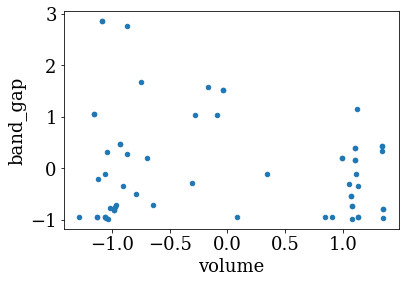

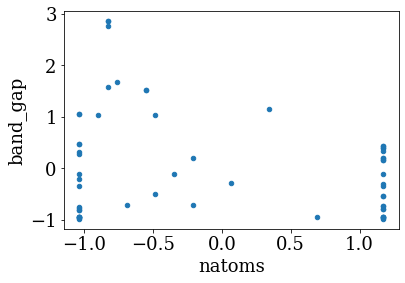

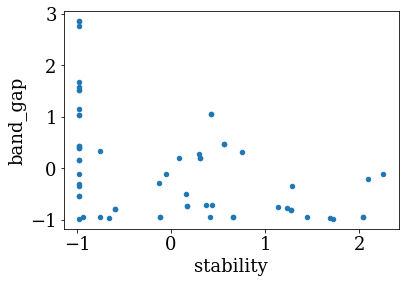

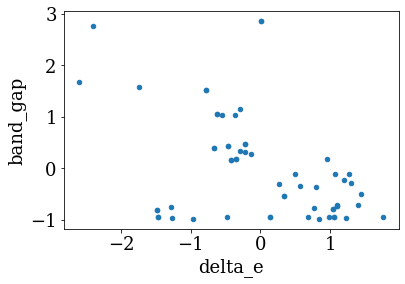

In [9]:
xmean = newxs.mean(axis=0)
xvar = np.sqrt(newxs.var(axis=0))
newxs = newxs-xmean
newys = newys-newys.mean(axis=0)
newxs = newxs/xvar
newys = newys/(np.sqrt(newys.var(axis=0)))

plt.rc('font', **font)
for i in range(len(indep_vars)):
    plt.scatter(newxs[:,i],newys,20)
    plt.xlabel(indep_vars[i])
    plt.ylabel(dep_var)
    plt.show()

3. Create a multi-variate linear regression model to predict the band gap energy from the other variables (molecular volume, number of atoms, formation energy, and molecular stability). Then, use the model to predict the band gap energy of all the datapoints. Report the $R^2$ value of the regression model.

In [37]:
regr = linear_model.LinearRegression()
model = regr.fit(newxs,newys)
y_preds = model.predict(newxs)
r2 = r2_score(newys,y_preds)
print('R2: ',r2)

R2:  0.65072860553565


4. Perform bootstrapping on the multivariate regression problem and create four different histograms, one for each of the $\textit{regression } \textit{parameters}$. You can use the `r2_bootstrapping` function from the discussion, but you will need to edit it to save values and create histograms of regression parameters instead of $R^2$ values.
Bootstrapping requirements: 
    - The number of bootstrapping samples per trial should be equal to the number of data points.
    - Use as many bootstrapping trials as you think are necessary.
    - Plot each histogram of regression parameters on the same plot. There should be 4 different histograms, one for each parameter (volume, number of atoms, formation energy, and molecular stability)

In [38]:
def param_bootstrap(xs, ys, n_samples, n_boot):
    '''
    Create a distribution of different R^2 values of a linear regression problem,
        predicting ys from xs
    inputs:
        xs: independent variables of data, 2D array
        ys: dependent variable of data, 1D array
        n_samples: number of samples to use for a bootstrapping trial, integer
        n_boot: number of bootstrapping trials to run, integer
    outputs:
        r2s: list of R2 values from each bootstrapping trial
    '''
    r2s = []
    regrs = []
    # run n_boot number of trials
    for i in range(n_boot):
        # create an array of indices of our dependent-variable array
        inds = range(len(ys))
        # create an array of randomly-sampled indices with n_samples number of samples
        boot = resample(inds, replace=True, n_samples=n_samples)
        # use the indices to choose random samples from the independent and dependent variable arrays
        samplex = xs[boot,:]
        sampley = ys[boot]
        # create regression model from the sampled data
        regr = linear_model.LinearRegression()
        model = regr.fit(samplex,sampley)
        # predict the dependent variable using the model
        y_preds = model.predict(samplex)
        # calculate the R^2 value of the fit
        r2 = r2_score(sampley,y_preds)
        # add this value to an array of R^2 values from every trial
        r2s.append(r2)
        regrs.append(regr.coef_)
    return np.array(regrs)

(500, 4)


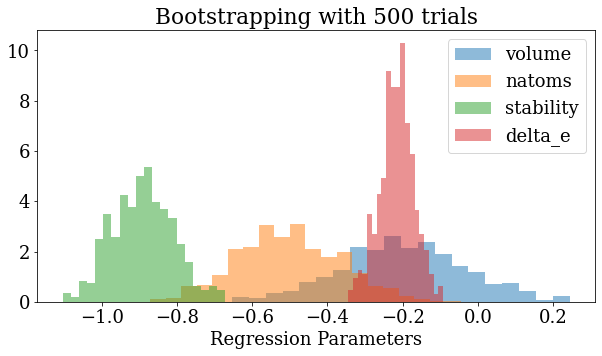

In [46]:
n_samp = len(ys)
n_boot = 500

coeffs = param_bootstrap(newxs,newys,n_samp,n_boot)
coeff_names = ['volume','natoms','stability','delta_e']
print(coeffs.shape)

figure,ax = plt.subplots(figsize=(10,5))
for i in range(4):
    ax.hist(coeffs[:,i],20,alpha=0.5,label=coeff_names[i],density=True);
ax.legend()
ax.set_xlabel('Regression Parameters')
ax.set_title('Bootstrapping with 500 trials')
plt.show()

#plt.plot(coeffs[:,0])

5. Clearly report the mean and variance of each histogram computed in part 4. Round each value to 4 decimal places. Report which independent variable has the bootstrapping histogram with the highest variance.

In [49]:
for i in range(4):
    mean = np.mean(coeffs[:,i])
    var = np.var(coeffs[:,i])
    print(coeff_names[i])
    print('mean:',round(mean,4),'var:',round(var,4))

volume
mean: -0.1983 var: 0.0276
natoms
mean: -0.5014 var: 0.0189
stability
mean: -0.891 var: 0.0066
delta_e
mean: -0.2169 var: 0.002


Volume has the highest variance of the four independent parameters.

6. Create a new multi-variate linear regression model to predict the band gap energy from the other variables $\textit{except}$ the highest-variance variable reported in part 5. Use this new model to predict the band gap energy of all the datapoints. Report the $R^2$ value of this new regression model. What is the difference between this $R^2$ value and that in part 3? $\textbf{Hint:}$ If the $R^2$ value is significantly smaller than that in part 3, then the parameter you removed was very important in predicting the band gap energy. If the difference is not very big or if the $R^2$ value is larger, then the parameter removed was useless in predicting the band gap energy. To help you check if your answer to this question is correct, consider what a large variance in the bootstrapping histogram suggests about the variable.

In [40]:
#remove volume variable
newxs_noVol = newxs[:,[1,2,3]]

regr_new = linear_model.LinearRegression()
model = regr.fit(newxs_noVol,newys)
y_preds = model.predict(newxs_noVol)
r2_new = r2_score(newys,y_preds)
print('R2: ',r2_new)

R2:  0.648284862514364


The new R2 value differs from the one in part 3 by less than 0.01, indicating that the model did not improve or get worse by removing the independant variable with the highest variance. This makes sense because large variance means that that parameter is not significantly involved in the model used to predict band gap. 